# 8-School Problem: Hierarchical Bayesian model
author: @anandShegde, @karm-patel

In this notebook, we fit a hierarchical Bayesian model to the "8 schools" dataset.
based on: https://github.com/probml/pyprobml/blob/master/notebooks/book2/03/schools8_pymc3.ipynb

In [1]:
%matplotlib inline
import jax
import jax.numpy as jnp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [2]:
# !pip install -qq -U pymc3>=3.8
try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq blackjax
    import blackjax

try:
    import probml_utils as pml
except:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils.blackjax_utils import inference_loop_multiple_chains, arviz_trace_from_states, inference_loop

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az

try:
    import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow_probability
    import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions

In [3]:
# import os

# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"

# Data

In [4]:
pml.latexify(fig_width=2, fig_height=1.5)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


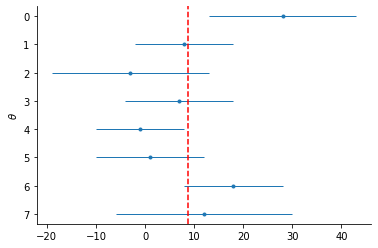

In [5]:
# https://github.com/probml/pyprobml/blob/master/scripts/schools8_pymc3.py

# Data of the Eight Schools Model
J = 8
treatment_effects = jnp.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
treatment_stddevs = jnp.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
names = []
for t in range(8):
    names.append("{}".format(t))

# Plot raw data
fig, ax = plt.subplots()
y_pos = jnp.arange(8)
ax.errorbar(treatment_effects, y_pos, xerr=treatment_stddevs, fmt="o", elinewidth=1, markersize=3)
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.axvline(jnp.mean(treatment_effects), color="r", linestyle="--", label="pooled MLE")
ax.set_ylabel("$\\theta$")
sns.despine()
pml.savefig("schools8_data")
plt.show()

# Centered model

In [6]:
mu_prior = tfd.Normal(loc=0, scale=5)
sigma_prior = tfd.Cauchy(loc=0, scale=5)
positive_fn = jax.nn.softplus


def log_post_fn_centered(params):
    mu, log_tou, theta = params["mu"], params["log_tou"], params["theta"].reshape((-1,))
    log_prior_mu = mu_prior.log_prob(mu)
    log_prior_tou = sigma_prior.log_prob(log_tou)

    # change of variable
    tou = positive_fn(log_tou)
    log_tou_jacob = jnp.log(jnp.abs(jax.jacfwd(positive_fn)(log_tou)))

    log_prior_theta = jnp.sum(tfd.Normal(mu, tou).log_prob(theta))
    log_like = 0
    log_like += jnp.sum(tfd.Normal(theta, treatment_stddevs).log_prob(treatment_effects))
    return log_like + log_prior_mu + log_prior_theta + log_prior_tou + log_tou_jacob

In [7]:
num_samples = 10_000
num_chains = 4
num_warmup = 25_000

In [8]:
key = jax.random.PRNGKey(311)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)

In [9]:
num_chains = 4
keys_warmup = jax.random.split(key_warmup, num_chains)
mu_inital = mu_prior.sample(seed=key_init, sample_shape=num_chains)
sigma_initial = sigma_prior.sample(seed=key_init, sample_shape=num_chains)
theta_initial = tfd.Normal(loc=mu_inital, scale=sigma_initial).sample(seed=key_init, sample_shape=8).T
params_centerd = {"mu": mu_inital, "log_tou": sigma_initial, "theta": theta_initial}

In [10]:
params_centerd_one = {"mu": mu_inital[0], "log_tou": sigma_initial[0], "theta": theta_initial[0]}

In [11]:
%%time
adapt = blackjax.window_adaptation(blackjax.nuts, log_post_fn_centered, num_warmup)
final_states_cent = jax.vmap(lambda key, param: adapt.run(key, param)[0])(keys_warmup, params_centerd)
final_state, kernel, _ = adapt.run(keys_warmup[1], params_centerd_one)
states_cent, infos_cent = inference_loop_multiple_chains(
    key_samples, kernel, final_states_cent, num_samples, num_chains
)

CPU times: user 19.5 s, sys: 256 ms, total: 19.8 s
Wall time: 19.6 s


In [12]:
infos_cent.is_divergent.sum(axis=0)

DeviceArray([ 1314,  2165, 10000, 10000], dtype=int32)

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


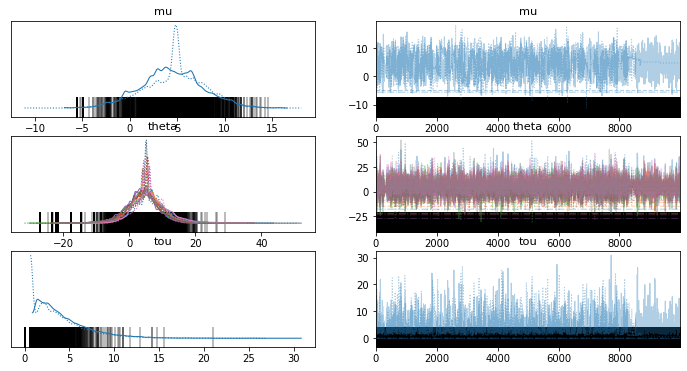

In [13]:
states_cent.position["tou"] = positive_fn(states_cent.position["log_tou"])
del states_cent.position["log_tou"]
trace_centered = arviz_trace_from_states(states_cent, infos_cent)
az.plot_trace(trace_centered);

In [14]:
az.summary(trace_centered)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.348,5.418,-5.527,8.371,2.467,1.862,5.0,4.0,2.28
theta[0],2.922,13.111,-17.633,15.847,6.249,4.750,5.0,4.0,2.02
theta[1],-3.800,9.684,-14.689,10.568,4.551,3.452,5.0,4.0,2.26
theta[2],4.967,5.511,-4.203,12.052,1.997,1.470,9.0,91.0,1.35
theta[3],-5.208,11.780,-22.210,10.399,5.645,4.362,5.0,4.0,2.25
theta[4],-5.715,13.076,-27.057,8.833,6.326,4.975,5.0,4.0,3.37
theta[5],-1.426,13.250,-23.232,9.560,6.401,4.976,6.0,4.0,1.76
theta[6],3.883,5.017,-1.476,14.234,1.707,1.250,8.0,4.0,1.55
theta[7],-2.072,12.003,-21.681,10.951,5.704,4.334,7.0,4.0,3.21
tou,2.096,3.071,0.000,7.729,1.083,0.796,5.0,4.0,2.32


In [15]:
# Display the total number and percentage of divergent chains
print("Number of Divergent Chains: {}".format(infos_cent.is_divergent.sum()))
diverging_pct = infos_cent.is_divergent.sum() / (num_samples * num_chains) * 100
print("Percentage of Divergent Chains: {:.1f}".format(diverging_pct))

Number of Divergent Chains: 23479
Percentage of Divergent Chains: 58.7


# Non-centered

In [16]:
mu_prior = tfd.Normal(loc=0, scale=5)
sigma_prior = tfd.Cauchy(loc=0, scale=5)
positive_fn = jax.nn.softplus


def log_post_fn_non_centered(params):
    mu, log_tou, eta = params["mu"], params["log_tou"], params["eta"]

    log_prior_mu = mu_prior.log_prob(mu)

    # change of variable
    tou = positive_fn(log_tou)
    log_prior_tou = sigma_prior.log_prob(log_tou)
    log_tou_jacob = jnp.log(jnp.abs(jax.jacfwd(positive_fn)(log_tou)))

    log_prior_eta = jnp.sum(tfd.Normal(0, 1).log_prob(eta))
    log_like = 0
    log_like += jnp.sum(tfd.Normal(mu + tou * eta, treatment_stddevs).log_prob(treatment_effects))
    return log_like + log_prior_mu + log_prior_eta + log_prior_tou + log_tou_jacob

In [17]:
potential = log_post_fn_non_centered

key = jax.random.PRNGKey(315)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)

mu_inital = mu_prior.sample(seed=key_init, sample_shape=num_chains)
sigma_initial = sigma_prior.sample(seed=key_init, sample_shape=num_chains)
eta_initial = tfd.Normal(loc=[0] * 4, scale=1).sample(seed=key_init, sample_shape=8).T

params_noncenterd = {
    "mu": mu_inital,
    "log_tou": sigma_initial,
    "eta": eta_initial,
}

params_noncenterd_one = {
    "mu": mu_inital[0],
    "log_tou": sigma_initial[0],
    "eta": eta_initial[0],
}

In [18]:
%%time
adapt = blackjax.window_adaptation(blackjax.nuts, log_post_fn_non_centered, num_warmup)
final_states_non_cent = jax.vmap(lambda key, param: adapt.run(key, param)[0])(keys_warmup, params_noncenterd)
final_state, kernel, _ = adapt.run(keys_warmup[1], params_noncenterd_one)
states_non_cent, infos_non_cent = inference_loop_multiple_chains(
    key_samples, kernel, final_states_non_cent, num_samples, num_chains
)

CPU times: user 16.1 s, sys: 193 ms, total: 16.3 s
Wall time: 16.1 s


In [19]:
states_non_cent.position["tou"] = positive_fn(states_non_cent.position["log_tou"])
del states_non_cent.position["log_tou"]

In [20]:
infos_non_cent.momentum["theta"] = infos_non_cent.momentum["eta"]
tou = jax.vmap(lambda x: jnp.array([x] * 8), in_axes=1, out_axes=1)(states_non_cent.position["tou"]).T
mu = jax.vmap(lambda x: jnp.array([x] * 8), in_axes=1, out_axes=1)(states_non_cent.position["mu"]).T
theta = states_non_cent.position["eta"] * tou + mu
states_non_cent.position["theta"] = theta

In [21]:
infos_non_cent.is_divergent.sum(axis=0)

DeviceArray([0, 0, 0, 0], dtype=int32)

In [22]:
trace_noncentered = arviz_trace_from_states(states_non_cent, infos_non_cent)

In [23]:
az.summary(trace_noncentered)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta[0],0.322,0.988,-1.494,2.190,0.005,0.005,47795.0,31597.0,1.0
eta[1],0.088,0.941,-1.701,1.841,0.004,0.005,52727.0,29147.0,1.0
eta[2],-0.082,0.965,-1.880,1.754,0.004,0.005,57151.0,30829.0,1.0
eta[3],0.056,0.940,-1.713,1.821,0.004,0.005,55805.0,30978.0,1.0
eta[4],-0.161,0.922,-1.918,1.586,0.004,0.005,54998.0,31150.0,1.0
eta[5],-0.076,0.944,-1.860,1.718,0.004,0.005,54764.0,31339.0,1.0
eta[6],0.355,0.958,-1.420,2.200,0.004,0.004,51898.0,30446.0,1.0
eta[7],0.075,0.977,-1.744,1.910,0.004,0.005,52212.0,31508.0,1.0
mu,4.390,3.335,-1.938,10.609,0.016,0.012,43451.0,28758.0,1.0
tou,3.618,3.210,0.001,9.311,0.028,0.026,23131.0,12870.0,1.0


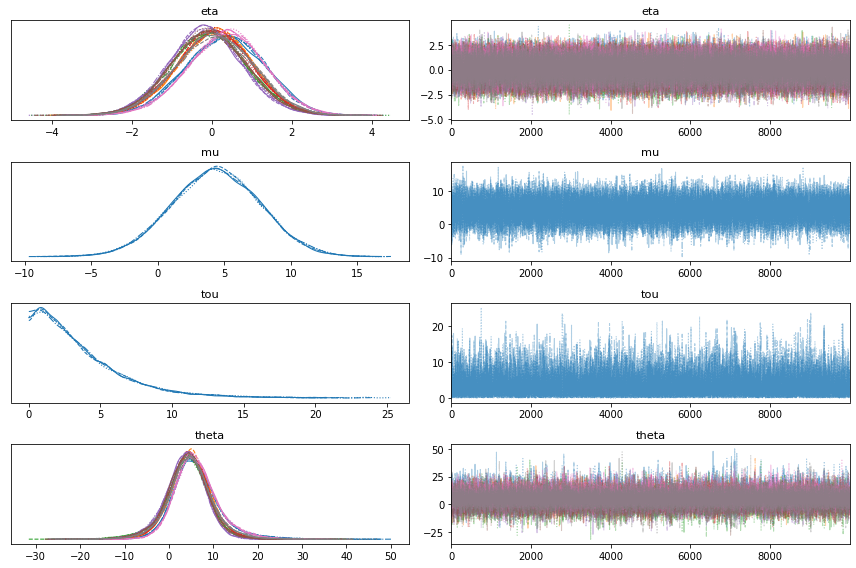

In [24]:
az.plot_trace(trace_noncentered)
plt.tight_layout()

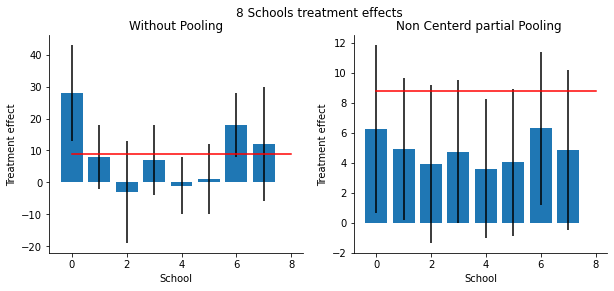

In [25]:
num_schools = 8
burnin = 300
# thetas = states_non_cent.position['eta']*jnp.mean(states_non_cent.position['tou'][burnin:])+jnp.mean(states_non_cent.position['mu'][burnin:])
thetas = states_non_cent.position["theta"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
ax2.bar(
    range(num_schools),
    jnp.mean(jnp.mean(thetas[burnin:, :], axis=0), axis=0),
    yerr=jnp.mean(jnp.std(thetas[burnin:, :], axis=0), axis=0),
)
ax1.plot([0, 8], [treatment_effects.mean(), treatment_effects.mean()], color="r", label="global mean")
ax2.plot([0, 8], [treatment_effects.mean(), treatment_effects.mean()], color="r", label="global mean")
ax1.set_xlabel("School")
ax1.set_ylabel("Treatment effect")
ax1.set_title("Without Pooling")
ax2.set_title("Non Centerd partial Pooling ")
sns.despine()
plt.suptitle("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
plt.show()

In [26]:
pml.latexify(fig_width=2)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


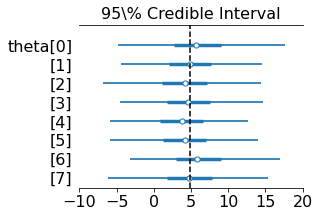

In [27]:
# with NonCentered_eight:
fig, ax = plt.subplots(figsize=(4, 3))
forest = az.plot_forest(trace_noncentered, var_names="theta", combined=True, hdi_prob=0.95, ax=ax, textsize=16)
forest[0].set_title("95\% Credible Interval", fontsize=16)
plt.axvline(jnp.mean(states_non_cent.position["theta"].mean()), color="k", linestyle="--")
forest[0].set_xticks([-10, -5, 0, 5, 10, 15, 20])
pml.savefig("hbayes_schools8_forest")

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


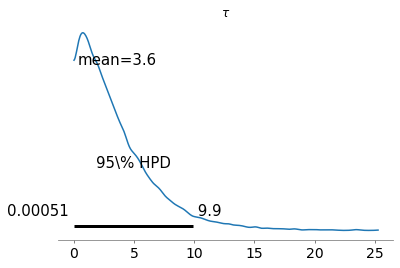

In [28]:
pml.latexify(width_scale_factor=2)
post_plot = az.plot_posterior(trace_noncentered, var_names="tou", hdi_prob=0.95)
post_plot.set_title("$\\tau$")

text = post_plot.get_children()[5]
text.set_text("95\% HPD")
pml.savefig("hbayes_schools8_tau")

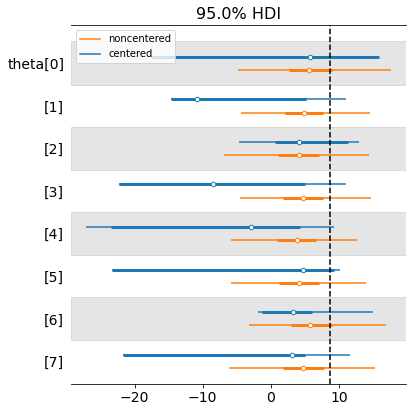

In [29]:
from cProfile import label


az.plot_forest(
    [trace_centered, trace_noncentered],
    model_names=["centered", "noncentered"],
    var_names="theta",
    combined=True,
    hdi_prob=0.95,
)
plt.axvline(jnp.mean(treatment_effects), color="k", linestyle="--")

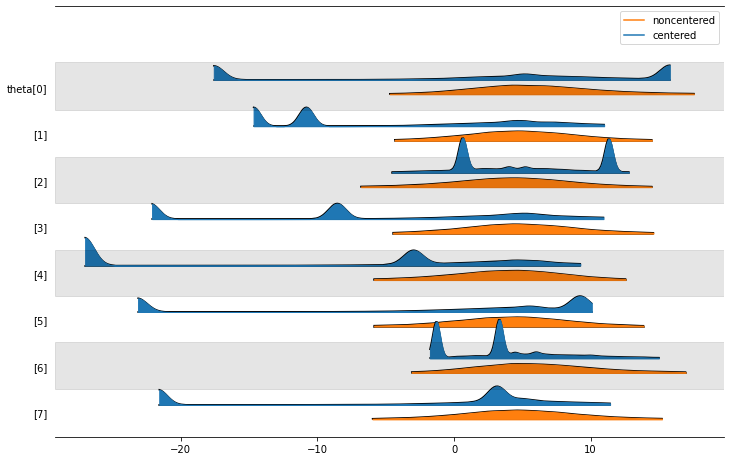

In [30]:
az.plot_forest(
    [trace_centered, trace_noncentered],
    model_names=["centered", "noncentered"],
    var_names=["theta"],
    kind="ridgeplot",
    combined=True,
    hdi_prob=0.95,
);

# Funnel of hell

In [31]:
pml.latexify(width_scale_factor=1.5, fig_height=2)
FIG_SIZE = None if pml.is_latexify_enabled() else (10, 5)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:25: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:84: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


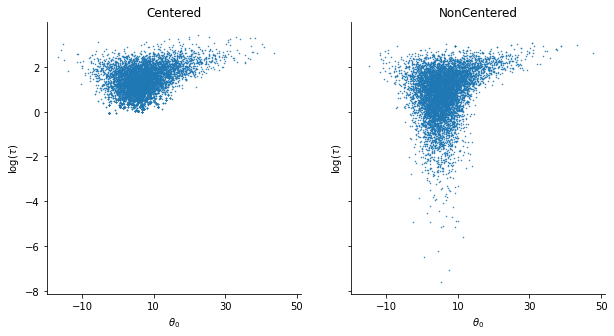

In [32]:
# Plot the "funnel of hell"
# Based on
# https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/GLM_hierarchical_non_centered.ipynb

burnin = num_samples // 4
group = 0
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=FIG_SIZE)
x = pd.Series(states_cent.position["theta"][burnin:, 0, group], name=f"alpha {group}")
y = pd.Series(jnp.log(states_cent.position["tou"][burnin:, 0]), name="log_sigma_alpha")
axs[0].plot(x, y, ".", markersize=1)
axs[0].set(title="Centered", xlabel=r"$\theta_0$", ylabel=r"$\log(\tau)$")
axs[0].set_xticks([-10, 10, 30, 50])

x = pd.Series(states_non_cent.position["theta"][burnin:, 0, group], name=f"alpha {group}")
y = pd.Series(jnp.log(states_non_cent.position["tou"][burnin:, 0]), name="log_sigma_alpha")
axs[1].plot(x, y, ".", markersize=1)
axs[1].set(title="NonCentered", xlabel=r"$\theta_0$", ylabel=r"$\log(\tau)$")

sns.despine()
pml.savefig("schools8_funnel_group0")

In [33]:
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/patel_karm/anaconda3/envs/py3713/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


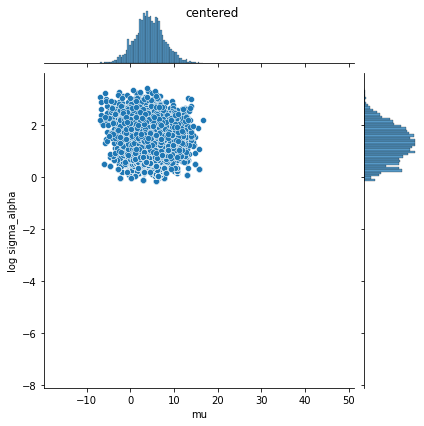

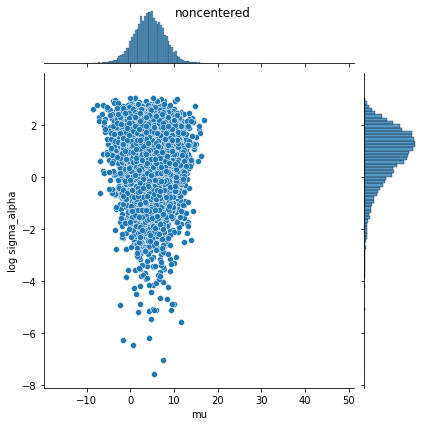

In [34]:
x = pd.Series(states_cent.position["mu"][:, 0], name="mu")
y = pd.Series(jnp.log(states_cent.position["tou"][:, 0]), name="log sigma_alpha")
sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle("centered")
plt.savefig("schools8_centered_joint.png", dpi=300)

x = pd.Series(states_non_cent.position["mu"][:, 0], name="mu")
y = pd.Series(jnp.log(states_non_cent.position["tou"][:, 0]), name="log sigma_alpha")
sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle("noncentered")
plt.savefig("schools8_noncentered_joint.png", dpi=300)

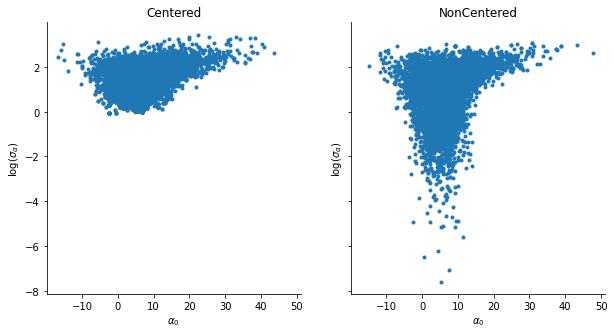

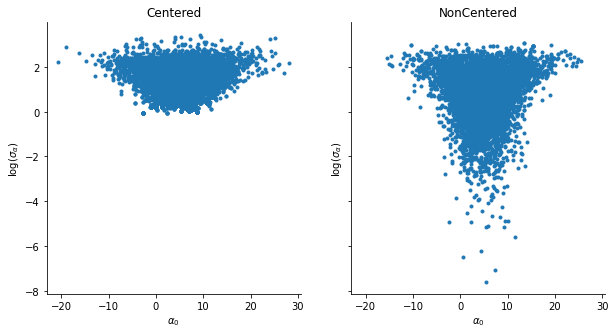

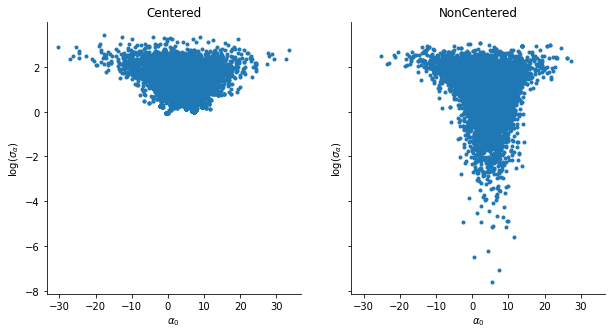

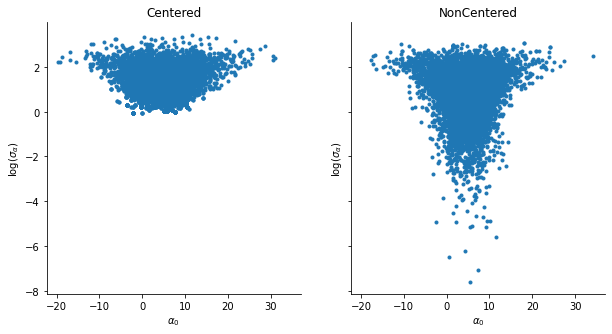

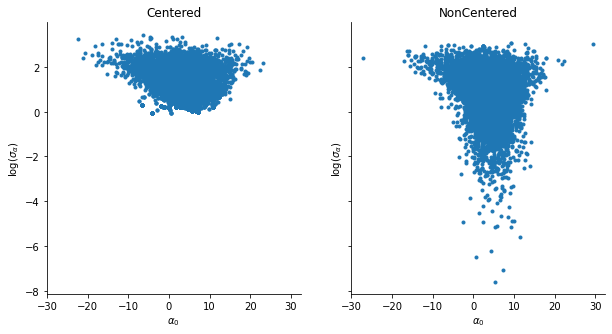

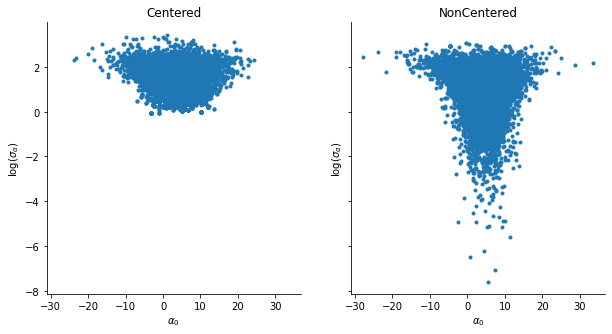

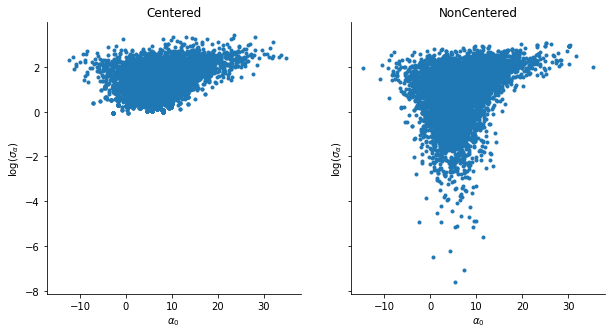

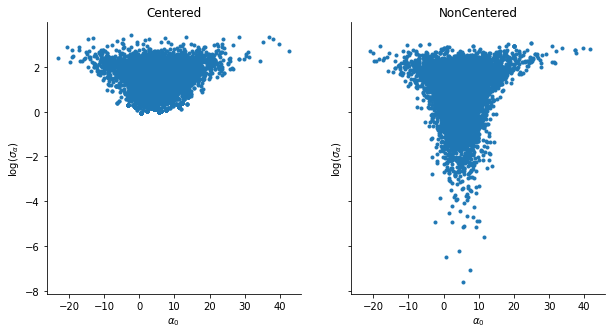

In [35]:
for group in range(8):
    burnin = num_samples // 4
    fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
    x = pd.Series(states_cent.position["theta"][burnin:, 0, group], name=f"alpha {group}")
    y = pd.Series(jnp.log(states_cent.position["tou"][burnin:, 0]), name="log_sigma_alpha")
    axs[0].plot(x, y, ".")
    axs[0].set(title="Centered", xlabel=r"$\alpha_0$", ylabel=r"$\log(\sigma_\alpha)$")

    x = pd.Series(states_non_cent.position["theta"][burnin:, 0, group], name=f"alpha {group}")
    y = pd.Series(jnp.log(states_non_cent.position["tou"][burnin:, 0]), name="log_sigma_alpha")
    axs[1].plot(x, y, ".")
    axs[1].set(title="NonCentered", xlabel=r"$\alpha_0$", ylabel=r"$\log(\sigma_\alpha)$")

    xlim = axs[0].get_xlim()
    ylim = axs[0].get_ylim()
    sns.despine()
    plt.savefig(f"schools8_funnel_group{group}.png", dpi=300)
    plt.show()